<a href="https://colab.research.google.com/github/fzanart/Socialz/blob/main/es_plus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scipy --upgrade

In [2]:
import numpy as np
import pandas as pd
import json
import networkx as nx
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive/')
import random
from scipy.stats import qmc
from tqdm import tqdm
import time

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# Read the data
df = pd.read_csv('/content/drive/MyDrive/Socialz/cobol_pullrequests.csv', usecols=['login', 'name'])
df

,login,name
0,vim-sroberge,vimaec/g3d
1,vim-sroberge,vimaec/g3d
2,vim-sroberge,vimaec/g3d
3,vim-sroberge,vimaec/g3d
4,mavimaec,vimaec/g3d
...,...,...
1328,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1329,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1330,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples
1331,joe-tingsanchali-sonarsource,SonarSource/sonar-scanning-examples


In [4]:
# Add user (u: ) repo (r: ) indicator for each node
df['login'] = df['login'].apply(lambda x: 'u: '+x)
df['name'] = df['name'].apply(lambda x: 'r: '+x)

In [5]:
# Build the adjacency matrix for user - repo (and repo - user) interactions.
adj_matrix = pd.crosstab(df['login'], df['name']).astype(float)
idx = adj_matrix.columns.union(adj_matrix.index)
adj_matrix = adj_matrix.reindex(index = idx, columns=idx, fill_value=0.0)

In [6]:
# Add user - user interactions.
matrix_elements = np.sort(df['login'].unique(), axis=0)
repo_len = len(df['name'].unique())

def cosine_similarity(vector_a, vector_b):
    
    norma = (np.linalg.norm(vector_a)*np.linalg.norm(vector_b))

    if norma > 0:

        cos_sim = np.dot(vector_a,vector_b)/ norma

    else:

        cos_sim = 0

    return cos_sim

#Initialise an auxiliar matrix to record the user - user similarities
shape = (len(matrix_elements), len(matrix_elements))
aux_matrix = pd.DataFrame((np.zeros(shape=shape)), columns=matrix_elements, index=matrix_elements)

for i in matrix_elements:
    for j in matrix_elements:

        # Compare row vectors
        aux_vector_a = adj_matrix.loc[i].to_numpy()[:repo_len]
        aux_vector_b = adj_matrix.loc[j].to_numpy()[:repo_len]
        
        score = cosine_similarity(aux_vector_a, aux_vector_b)
        aux_matrix.at[i, j] = score

In [7]:
# Set the diagonal to 0 (Same user-user interaction = 0)
np.fill_diagonal(aux_matrix.to_numpy(), 0)

In [8]:
# Fill adj_matrix with aux_matrix data
for column in aux_matrix.columns:
    for row in aux_matrix.index:

        aux = aux_matrix.at[row, column]
        adj_matrix.at[row, column] = aux

In [9]:
# Compute graph metrics

def graph_metrics(adj_matrix):
  # Build the initial graph from adj_matrix.
  G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)
  d = {'degree' : {node:val for (node, val) in G.degree()} ,      # measure of activity of the node.
       'betweenness_centrality' : nx.betweenness_centrality(G)}   # measure of relative importance of the node.

  metric_df = pd.DataFrame(d)

  # normalise node degree values  https://www.statology.org/normalize-data-between-0-and-1/
  # zi = (xi – min(x)) / (max(x) – min(x))
  metric_df['degree'] = metric_df['degree'].apply(lambda x: (x - metric_df['degree'].min())/(metric_df['degree'].max() - metric_df['degree'].min()))
  
  #TODO:  filter users
  
  return metric_df

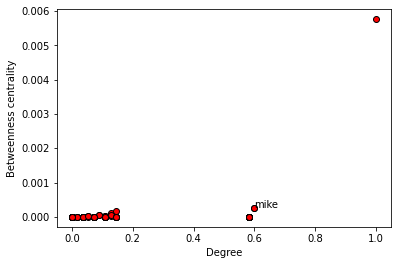

In [10]:
# Evaluate degree and betweenness centrality.
metric_df = graph_metrics(adj_matrix)

# Plot graph metric distribution, filtered by users.
metric_udf = metric_df[metric_df.index.str.startswith('u: ')]

fig, ax = plt.subplots()
ax.scatter(metric_udf['degree'],metric_udf['betweenness_centrality'],edgecolor="k", c="r")
ax.set_xlabel('Degree')
ax.set_ylabel('Betweenness centrality')
ax.annotate('mike', (metric_udf.loc['u: mikeharrisontelia'][0], metric_udf.loc['u: mikeharrisontelia'][1]))

plt.show()

# 'u: ralphnuessecpwr'       #'u: mikeharrisontelia'    #'u: fabiocosta0305'

In [11]:
# Evaluate metrics in terms of star-discrepancy
def objective(candidate):
  return qmc.discrepancy(candidate, method='L2-star',workers=-1)

In [12]:
# Initial evluation 
objective(metric_df)

0.6763834378398914

In [13]:
# Mutator, give it an adj_matrix, and it will return the mutated adj_matrix.

def mutate(adj_matrix, node): # Do I nedd to pass the node? or should I ramdomly choose one?

  am = adj_matrix.copy()

  # Create a graph from the adj. matrix, and list the connected componnets.
  G = nx.from_pandas_adjacency(am, create_using=nx.DiGraph)
  connected_components = list(nx.weakly_connected_components(G))

  # Define a method to return the connected component of a particular node.
  def get_component(node, connected_components):
    for component in connected_components:
      if node in component:
        return component
    else:
      return set()

  # get adj_matrix of the node's connected component (sub graph) 
  sub_am = nx.to_pandas_adjacency(G, list(get_component(node, connected_components)))

  # Mutate, keep iterating (shuffling) until .loc[node,node] = 0.0
  aux = False
  while aux is False:
    np.random.shuffle(sub_am.loc[node]) # to ignore warning try sample(frac=1)
    if sub_am.loc[node,node] == 0.0:
      aux = True

  # Fill adj_matrix with sub graph adj. matrix (sub_am) data
  for column in sub_am.columns:
      for row in sub_am.index:

          aux = sub_am.at[row, column]
          am.at[row, column] = aux

  return am

In [15]:
# evolution strategy (mu, lambda) algorithm
def es_plus(initial_record, objective, n_iter, mu, lam):
  best, best_eval = None, 1e+10
	# calculate the number of children per parent
  n_children = int(lam / mu)
	
  # initial population
  population = list()
  
  for i in range(lam):
    candidate = initial_record.copy()       # copy the initial matrix
    sample = candidate.sample(1).index[0]  # get a random node
    candidate = mutate(candidate, sample)   # mutate
    population.append(candidate)            # add to population

  # perform the search
  for epoch in range(n_iter):
    # evaluate the fitness for the population
    scores = [objective(graph_metrics(candidate)) for candidate in population]
    # rank scores in ascending order
    ranks = np.argsort(np.argsort(scores))
    # select the indexes for the top mu ranked solutions, drop the worse results	
    selected = [i for i,_ in enumerate(ranks) if ranks[i] < mu]
    # create offspring from parents
    offspring = list()
    for i in selected:
      # check if this parent is the best solution ever seen
      if scores[i] < best_eval:
        best, best_eval = population[i], scores[i]
        print('%d, Best eval: = %.5f' % (epoch, best_eval))
        
        # keep the parent
        offspring.append(population[i])

        # create offspring for parent
        for j in range(n_children):

          sample = population[i].sample(1).index[0]
          child = mutate(population[i], sample)
          offspring.append(child)

    # replace population with children
    population = offspring

  return [best, best_eval]

In [16]:
# define the total iterationsja
n_iter = 20000
# number of parents selected
mu = 1
# the number of children generated by parents
lam = 20
# perform the evolution strategy (mu, lambda) search
best, score = es_plus(adj_matrix, objective, n_iter, mu, lam)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: UserWarning: you are shuffling a 'Series' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.


0, Best eval: = 0.67471
1, Best eval: = 0.67295
2, Best eval: = 0.66241
3, Best eval: = 0.66039
4, Best eval: = 0.66037
5, Best eval: = 0.66035
6, Best eval: = 0.65818
7, Best eval: = 0.65816
8, Best eval: = 0.65815
9, Best eval: = 0.65812
10, Best eval: = 0.65592
11, Best eval: = 0.65592


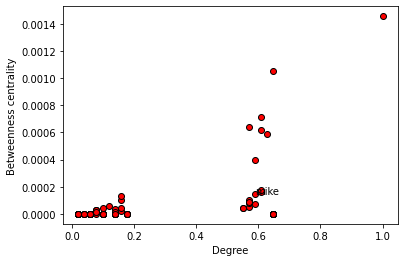

In [17]:
node = 'u: mikeharrisontelia'       

metric = graph_metrics(best)

metric_u = metric[metric.index.str.startswith('u: ')]

fig, ax = plt.subplots()
ax.scatter(metric_u['degree'],metric_u['betweenness_centrality'],edgecolor="k", c="r")
ax.set_xlabel('Degree')
ax.set_ylabel('Betweenness centrality')
ax.annotate('mike', (metric_u.loc[node][0], metric_u.loc[node][1]))

plt.show()

In [22]:
# Initial graph G
G = nx.from_pandas_adjacency(adj_matrix, create_using=nx.DiGraph)

# Optimised graph N
N = nx.from_pandas_adjacency(best, create_using=nx.DiGraph)
d = {'Info':[nx.info(G), nx.info(N)], 
     'Components':[nx.number_weakly_connected_components(G), nx.number_weakly_connected_components(N)]}

pd.DataFrame(d, index=['G', 'N'])

,Info,Components
G,DiGraph with 262 nodes and 846 edges,74
N,DiGraph with 262 nodes and 846 edges,75


In [19]:
pos = nx.spring_layout(G)

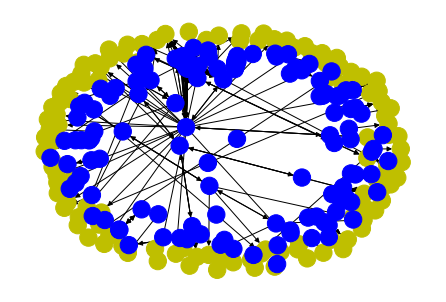

In [20]:
color_map = ['b' if node.startswith('u: ') else 'y' for node in G]
nx.draw(G, node_color=color_map, pos = pos)


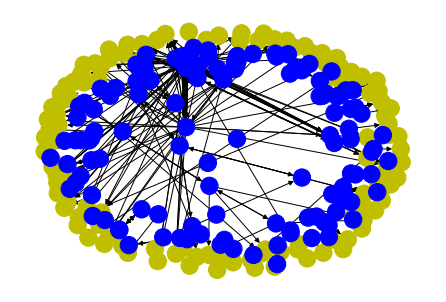

In [21]:
color_map = ['b' if node.startswith('u: ') else 'y' for node in N]
nx.draw(N, node_color=color_map, pos = pos)